In [4]:
import pandas as pd
df = pd.read_csv('./homo_sapiens.tsv', sep='\t')
df['Gene Names'] = df['Gene Names'].str.split(',')
unique_genes = set(df['Gene Names'].explode())
print(f"Total number of unique genes: {len(unique_genes)}")


Total number of unique genes: 40993


In [50]:

# Step 1: Extract genes from perturbation_gene_found.csv
def extract_genes(file_path):
    df = pd.read_csv(file_path)
    genes = df['Gene'].tolist()
    return genes

perturbation_genes = extract_genes("perturabtion_gene_found.csv")

# Step 2: Load and process the homo_sapiens.tsv file
df = pd.read_csv('homo_sapiens.tsv', sep='\t')
df['Gene Names'] = df['Gene Names'].str.split(' ')
unique_genes = set(df['Gene Names'].explode())

# Filter out non-string types (e.g., NaN values that become floats after explode)
filtered_unique_genes = {gene for gene in unique_genes if isinstance(gene, str)}

# Now you can safely sort the filtered set
sorted_unique_genes = sorted(filtered_unique_genes)

# Step 3: Find genes only in perturbation genes
missing = set(perturbation_genes) - set(sorted_unique_genes)
print(missing)
print(f"Count of perturbation genes: {len(set(perturbation_genes))}")
print(f"Count of unique perturbation genes not found in homo_sapiens.tsv: {len(missing)}")



{'HIST2H3A', 'HIST2H2AA3', 'ALG1L', 'control', 'AC118549.1'}
Count of perturbation genes: 2491
Count of unique perturbation genes not found in homo_sapiens.tsv: 5


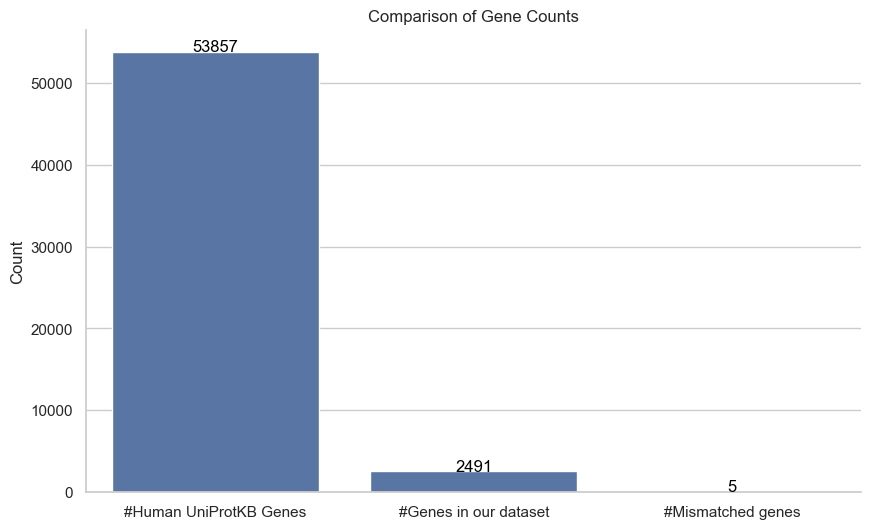

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data for histogram
data = [len(unique_genes), len(set(perturbation_genes)), len(missing)]

labels = ['#Human UniProtKB Genes', '#Genes in our dataset', '#Mismatched genes']
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=data)
plt.title('Comparison of Gene Counts')
plt.ylabel('Count')
for index, value in enumerate(data):
    plt.text(index, value, str(value), color='black', ha="center")
sns.despine()
plt.show()


In [29]:
import pandas as pd
import torch

# Step 1: Extract genes from perturbation_gene_found.csv
def extract_genes(file_path):
    df = pd.read_csv(file_path)
    genes = df['Gene'].tolist()
    return genes

perturbation_genes = extract_genes("perturabtion_gene_found.csv")

# Step 2: Load gene embeddings and extract gene names
gene_vector_averages = torch.load('gene_vector_averages.pt')
gene_names_from_embeddings = list(gene_vector_averages.keys())

# Ensure gene names are unique and sorted
sorted_unique_gene_names_from_embeddings = set(gene_names_from_embeddings)

# Step 3: Perform the intersection
missing = set(perturbation_genes) - set(sorted_unique_gene_names_from_embeddings)
print(len(set(perturbation_genes)))
print(len(set(sorted_unique_gene_names_from_embeddings)))
print(f"Count of perturbation genes: {len(perturbation_genes)}")
print(f"Count of unique perturbation genes not found in gene_vector_averages.pt: {len(missing)}")

2491
53768
Count of perturbation genes: 2491
Count of unique perturbation genes not found in gene_vector_averages.pt: 5


Seems like there are 5 missing genes both in the original tsv file and also in the gene embeddings - progress!.
If we explore uniprot we can see that out of the 4 missing genes (skipping control):

* HIST2H3A is synonym for H3C15 
* HIST2H2AA3 is synonym for H2AFO  

and

* ALG1L1P seems to be a pseudogene?
* AC118549.1 has been replaced by AC118549, but the entry still seems iffy

It seems reasonable to replace the embeddings for the first 2 by their synonyms. Let's see if these 2 exist:



In [31]:
synonyms = ["H3C15", "H2AFO"]
found_synonyms = [gene for gene in synonyms if gene in sorted_unique_gene_names_from_embeddings]
print(f"Found synonyms in gene embeddings: {found_synonyms}")


Found synonyms in gene embeddings: ['H3C15', 'H2AFO']


In [38]:
df = pd.read_csv("homo_sapiens.tsv", sep='\t')
protein_gene_map = df.groupby('Entry')['Gene Names'].apply(list)
shared_proteins = protein_gene_map[protein_gene_map.apply(len) > 1]
print(f"Proteins mapped by multiple genes: {shared_proteins}")


Proteins mapped by multiple genes: Series([], Name: Gene Names, dtype: object)


Seems like the mapping from protein to gene is one to one. 

In [7]:
from generate_gene_embeddings.generate_gene_embeddings.create_gene_protein_map.create_gene_protein_map import \
    create_gene_protein_map

protein_map = create_gene_protein_map("./homo_sapiens.tsv")
filtered_protein_map = {gene: proteins for gene, proteins in protein_map.items() if gene in perturbation_genes}


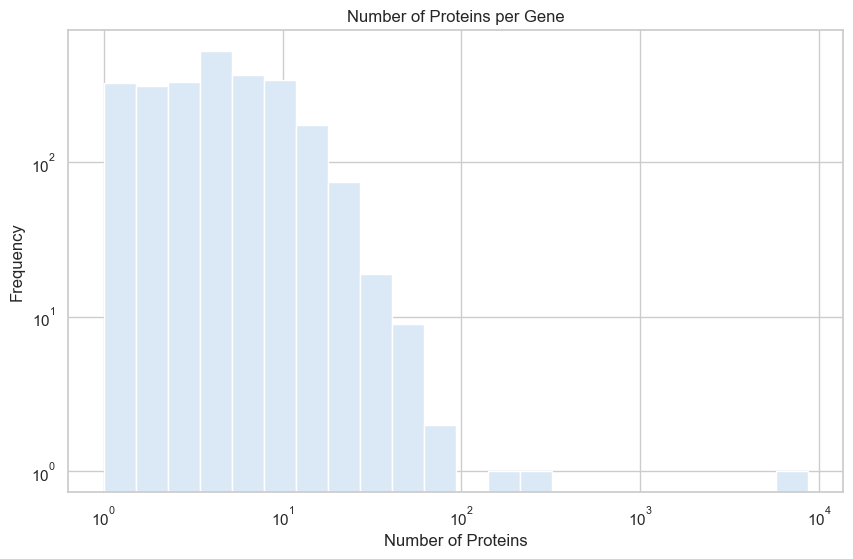

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of proteins per gene
num_proteins_per_gene = [len(proteins) for proteins in filtered_protein_map.values()]

sns.set_palette("Blues")

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

# Plot histogram with seaborn
plt.figure(figsize=(10, 6))
plot_loghist(num_proteins_per_gene, 22)
plt.title('Number of Proteins per Gene')
plt.xlabel('Number of Proteins')
plt.ylabel('Frequency')
plt.yscale("log")
plt.show()


    Group  Count
0       1    325
1       2    313
2       3    329
3       4    284
4       5    239
5    6-10    561
6   10-50    426
7  50-100      6
8    100+      3


C:\Users\marti\AppData\Local\Temp\ipykernel_25008\2819995704.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y='Count', data=grouped_counts, palette='Blues')


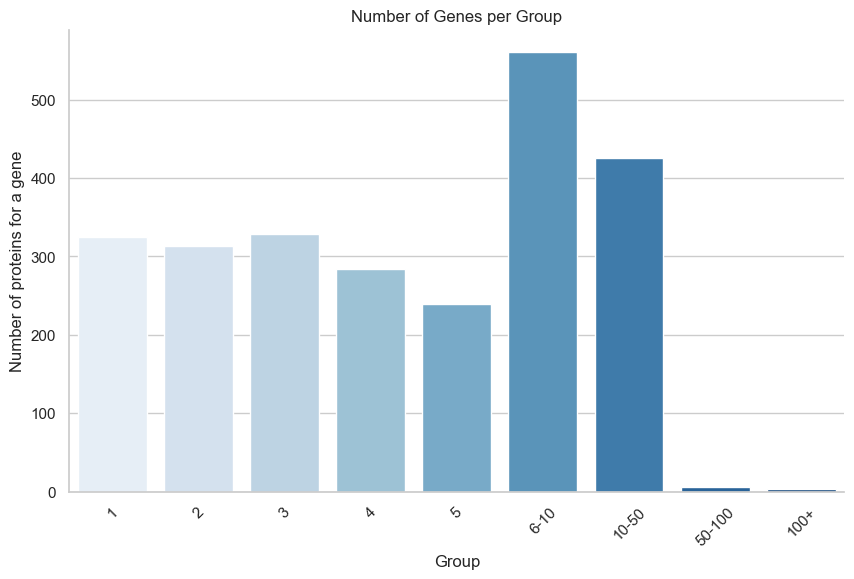

In [76]:
import pandas as pd

# Create a DataFrame from the filtered protein map
df = pd.DataFrame({'Gene': list(filtered_protein_map.keys()), 'NumProteins': [len(proteins) for proteins in filtered_protein_map.values()]})

# Define the bins for grouping
bins = [1, 2, 3, 4, 5, 6, 10, 50, 100, np.inf]
labels = ['1', '2', '3', '4', '5', '6-10', '10-50', '50-100', '100+']

# Group the data according to the number of proteins
df['Group'] = pd.cut(df['NumProteins'], bins=bins, labels=labels, right=False)

# Count the number of genes in each group
grouped_counts = df.groupby('Group').size().reset_index(name='Count')

# Display the table
print(grouped_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x='Group', y='Count', data=grouped_counts, palette='Blues')
plt.title('Number of Genes per Group')
plt.xlabel('Group')
plt.ylabel('Number of proteins for a gene')
plt.xticks(rotation=45)
sns.despine()
plt.show()



In [78]:
average_num_proteins = df['NumProteins'].mean()
std_dev_num_proteins = df['NumProteins'].std()

print(f"Average number of proteins per gene: {average_num_proteins}")
print(f"Standard deviation of proteins per gene: {std_dev_num_proteins}")


Average number of proteins per gene: 9.699919549477071
Standard deviation of proteins per gene: 174.09794202256606


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 53768 samples in 0.159s...
[t-SNE] Computed neighbors for 53768 samples in 210.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 53768
[t-SNE] Computed conditional probabilities for sample 2000 / 53768
[t-SNE] Computed conditional probabilities for sample 3000 / 53768
[t-SNE] Computed conditional probabilities for sample 4000 / 53768
[t-SNE] Computed conditional probabilities for sample 5000 / 53768
[t-SNE] Computed conditional probabilities for sample 6000 / 53768
[t-SNE] Computed conditional probabilities for sample 7000 / 53768
[t-SNE] Computed conditional probabilities for sample 8000 / 53768
[t-SNE] Computed conditional probabilities for sample 9000 / 53768
[t-SNE] Computed conditional probabilities for sample 10000 / 53768
[t-SNE] Computed conditional probabilities for sample 11000 / 53768
[t-SNE] Computed conditional probabilities for sample 12000 / 53768
[t-SNE] Computed conditional probabilities for 

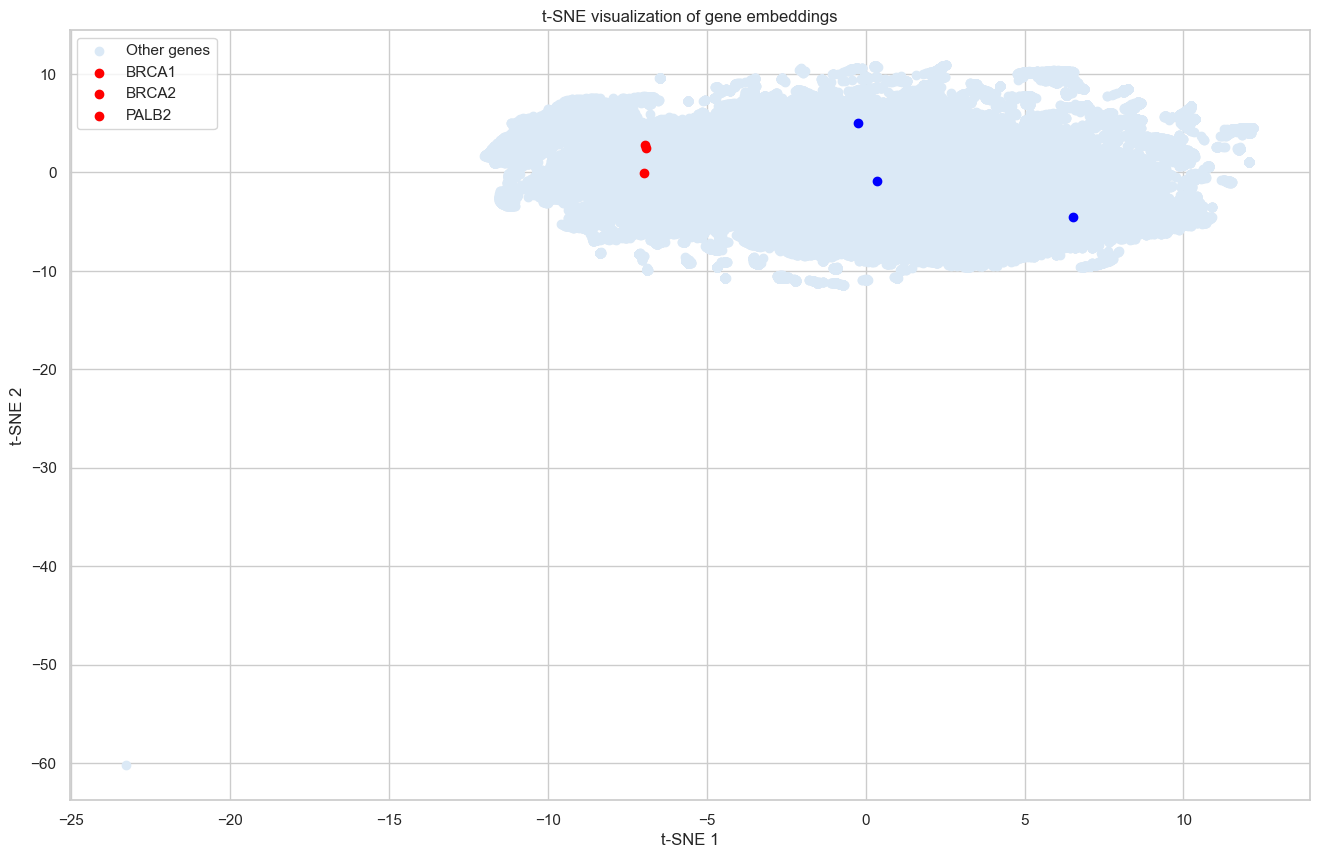

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Load the embeddings
embeddings = torch.load('gene_vector_averages.pt')

# Assuming 'embeddings' is a dictionary with gene names as keys and embedding vectors as values
embedding_values = list(embeddings.values())  # Extract the embedding vectors
genes = list(embeddings.keys())

# Check if all embeddings are of the same length
lengths = [len(vec) for vec in embedding_values]
if len(set(lengths)) > 1:
    raise ValueError("Not all embedding vectors are of the same length.")

# Convert to a 2D array
embedding_matrix = np.stack(embedding_values)

# Run t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_matrix)

# Highlight specific genes
breast_genes = ['BRCA1', 'BRCA2', 'PALB2']
melanoma_genes = ['TP53RK', 'BAP1', 'PTEN']
highlight_genes = breast_genes + melanoma_genes

# Extract indices of the genes to highlight
highlight_indices = [genes.index(gene) for gene in highlight_genes if gene in genes]

# Extract t-SNE results for highlighted genes
highlight_tsne_results = tsne_results[highlight_indices]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], label='Other genes')

# Plot highlighted genes with different colors
for i, gene in enumerate(highlight_genes):
    idx = genes.index(gene)
    color = 'red' if gene in breast_genes else 'blue'
    if gene in breast_genes:
        label = gene if breast_genes.index(gene) == 0 else ""
    else:
        label = gene if melanoma_genes.index(gene) == 0 else ""
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], color=color, label=label)

plt.title('t-SNE visualization of gene embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

